# Predict Housing Prices
- pass your own list of zip codes to predict future housing prices
- data from: https://www.zillow.com/research/data/ (download new data for more recent results)

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm as log_progress
from ipywidgets import widgets
from IPython.display import display, clear_output
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scalecast import GridGenerator
from scalecast.Forecaster import Forecaster
from scalecast.notebook import tune_test_forecast, results_vis

In [2]:
# add more/different models to this tuple
models = ("knn", "svr", "elasticnet", "mlp", "gbt", "prophet")
sns.set(rc={"figure.figsize": (12, 8)})

In [3]:
GridGenerator.get_example_grids()  # use overwrite=True to overwrite an existing Grids file

In [4]:
df = pd.read_csv(
    "Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv", dtype={"RegionName": str}
).set_index("RegionName")

In [5]:
df.head()

,RegionID,SizeRank,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,...,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31
RegionName,,,,,,,,,,,,,,,,,,,,,
United States,102001,0,Country,NaN,127090.0,127434.0,127795.0,128532.0,129274.0,130015.0,...,278389.0,282245.0,286948.0,292471.0,298349.0,303739.0,308359.0,312452.0,316333.0,320662.0
"New York, NY",394913,1,Msa,NY,223496.0,224831.0,226033.0,228398.0,230600.0,232945.0,...,523812.0,528535.0,534026.0,541165.0,549066.0,556634.0,562515.0,567048.0,570588.0,573813.0
"Los Angeles-Long Beach-Anaheim, CA",753899,2,Msa,CA,231337.0,232142.0,233376.0,235722.0,238237.0,240612.0,...,757038.0,768091.0,783767.0,803587.0,824502.0,837956.0,847074.0,851836.0,859045.0,868350.0
"Chicago, IL",394463,3,Msa,IL,168878.0,169276.0,169792.0,170824.0,171917.0,173001.0,...,260755.0,263775.0,266508.0,270301.0,274437.0,278525.0,281576.0,284217.0,286894.0,289595.0
"Dallas-Fort Worth, TX",394514,4,Msa,TX,130599.0,130703.0,130790.0,131002.0,131225.0,131411.0,...,285247.0,290780.0,297205.0,304541.0,312359.0,320271.0,327472.0,333559.0,339033.0,344919.0


## Select Zip Codes

In [6]:
# overwrite these regions with a list of your own - make sure there are enough observations
regions = [
    "New York, NY",
    "Salt Lake City, UT",
    "Orlando, FL",
    "Los Angeles-Long Beach-Anaheim, CA",
    "Seattle, WA",
]
regions

['New York, NY',
 'Salt Lake City, UT',
 'Orlando, FL',
 'Los Angeles-Long Beach-Anaheim, CA',
 'Seattle, WA']

In [7]:
assert len([r for r in regions if r in df.index.to_list()]) == len(
    regions
), "the following region names are invalid: {}".format(
    [r for r in regions if r not in df.index.to_list()]
)

In [8]:
# loads sliced dataframe into forecaster objects stored in a dict
preds = {}
for r in regions:
    data_load = df.loc[r].transpose()
    f = Forecaster(y=data_load.values[8:],current_dates=data_load.index[8:],name=r)
    f.set_test_length(12)
    preds[r] = f

## EDA
- last series only
- use only training set to avoid leakage

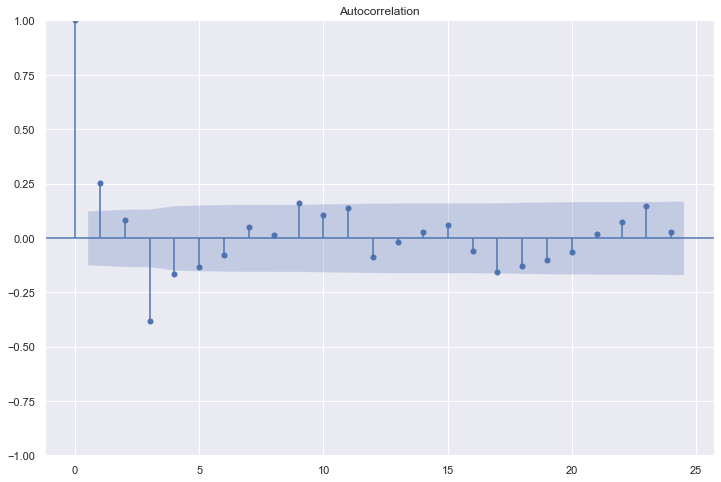

In [9]:
f.plot_acf(diffy=2,train_only=True)
plt.show()

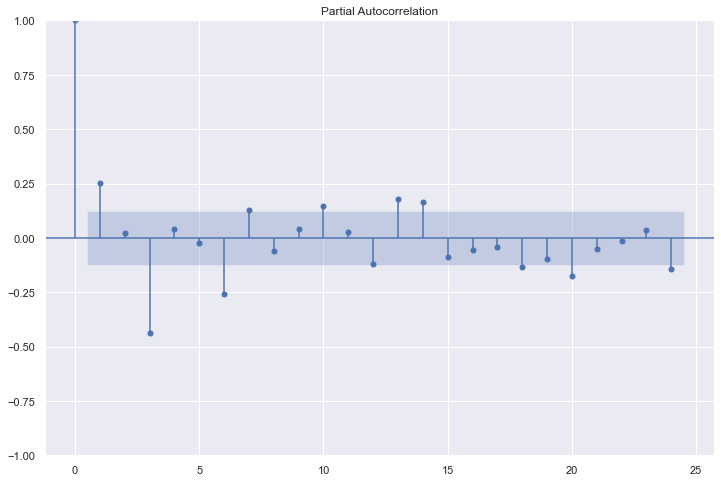

In [10]:
f.plot_pacf(diffy=2,train_only=True)
plt.show()

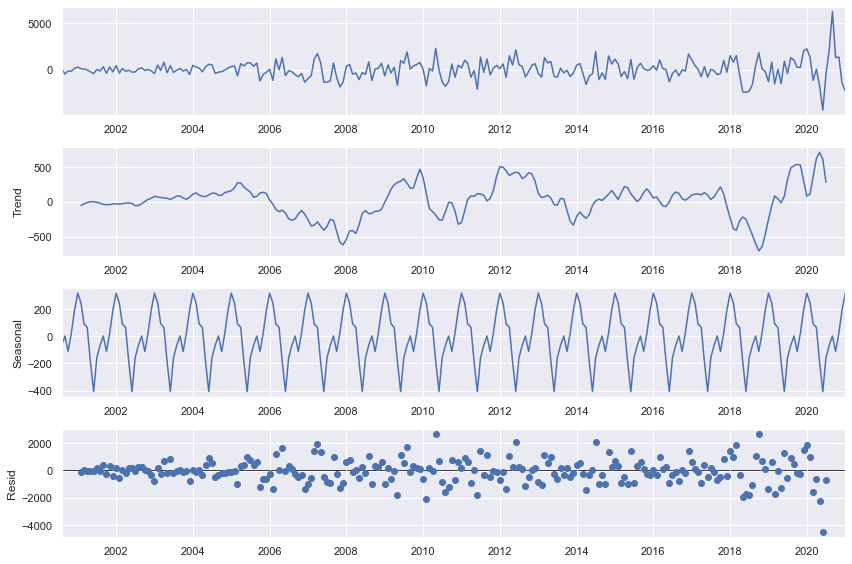

In [11]:
f.seasonal_decompose(diffy=2,train_only=True).plot()
plt.show()

## Predict future values
- using second differenced data for stationarity

In [12]:
# full forecast process
for k, f in log_progress(preds.items()):
    print(f'forcasting with {len(models)} models for {k}')
    f.generate_future_dates(12)
    f.set_validation_length(6)
    f.add_ar_terms(3)
    f.add_AR_terms((4,3))
    f.add_AR_terms((2,12))
    f.integrate()
    f.add_seasonal_regressors('month','quarter',raw=False,dummy=True)
    f.add_seasonal_regressors('year')
    f.add_other_regressor(called='2008_recession',start='2007-10-01',end='2009-06-30')
    f.add_time_trend(called='t')
    f.add_poly_terms('t',pwr=3)
    
    tune_test_forecast(f,models)
        
    f.set_estimator('combo')
    # top based on performance of each model in tuning process
    f.manual_forecast(how='simple',models='top_3',call_me='avg')
    f.manual_forecast(how='weighted',models='top_5',call_me='weighted')

  0%|          | 0/5 [00:00<?, ?it/s]

forcasting with 6 models for New York, NY


  0%|          | 0/6 [00:00<?, ?it/s]

forcasting with 6 models for Salt Lake City, UT


  0%|          | 0/6 [00:00<?, ?it/s]

forcasting with 6 models for Orlando, FL


  0%|          | 0/6 [00:00<?, ?it/s]

forcasting with 6 models for Los Angeles-Long Beach-Anaheim, CA


  0%|          | 0/6 [00:00<?, ?it/s]

forcasting with 6 models for Seattle, WA


  0%|          | 0/6 [00:00<?, ?it/s]

## Write out model stats

In [13]:
# writes model summaries to a csv file
model_summaries = pd.DataFrame()
for k, f in preds.items():
    df = f.export(dfs='model_summaries',determine_best_by='LevelTestSetMAPE')
    df['Name'] = k
    model_summaries = pd.concat([model_summaries,df],ignore_index=True)
    
model_summaries.to_csv('model_summaries.csv',index=False)

## Visualize results

In [16]:
results_vis(preds,'forecast',print_attr=['Integration'])

Dropdown(description='Time Series:', options=('New York, NY', 'Salt Lake City, UT', 'Orlando, FL', 'Los Angele…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6, 7, 8), value=1)

Dropdown(description='View Level', options=(True, False), value=True)

Dropdown(description='View Confidence Intervals', options=(True, False), value=True)

Dropdown(description='Order By', options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE', 'LevelT…

Button(description='Select Time Series', style=ButtonStyle())

Output()

In [15]:
results_vis(preds,'test')

Dropdown(description='Time Series:', options=('New York, NY', 'Salt Lake City, UT', 'Orlando, FL', 'Los Angele…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6, 7, 8), value=1)

Dropdown(description='View Level', options=(True, False), value=True)

Dropdown(description='View Confidence Intervals', options=(True, False), value=True)

Dropdown(description='Order By', options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE', 'LevelT…

Button(description='Select Time Series', style=ButtonStyle())

Output()